#### Figures and analysis for Duffey et al., (2023) 'Rapid Arctic Warming Will Push Global Temperatures Past 1.5C Target Five Years Earlier'
Notebook plots and calculates summary statistics for global and 'world without arctic' surface temperature projections

Author: Alistair Duffey, alistair.duffey.21@ucl.ac.uk

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator

import numpy as np
import xarray as xr
import os
import glob
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import scipy.stats as stats

def make_df(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    return df

def get_baseline(df, t_bnds=[1850, 1900], monthly=False, multi_ens=False):
    df_hist = df[df['Experiment']=='historical']
    
    df_hist = df_hist[(df_hist['year'] > t_bnds[0]) & (df_hist['year'] < t_bnds[1])]
    
    df_hist['base_t_bnds'] = str(t_bnds[0]) + '-' + str(t_bnds[1])
    if monthly:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds', 'Month']).mean().reset_index().rename(columns=baseline_name_changes)
    else:
        if multi_ens:
            df_hist = df_hist.groupby(['Model', 'Ensemble_member', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
        else:
            df_hist = df_hist.groupby(['Model', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
    df_hist = df_hist.drop(columns=['year'])
    return df_hist

def wmean(df, values, weights):
    return sum(df[weights]*df[values])/df[weights].sum()

def preprocess_hadcrut_z(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['Year'].between(preind_period[0], preind_period[1])]
    offset = df_pre_ind['Anomaly (deg C)'].mean()
    df_out = df[['Year', 'Anomaly (deg C)']]
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'] - offset
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'].rolling(window, center=True).mean()
    return df_out

def preprocess_obs(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    #df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['year'].between(preind_period[0], preind_period[1])]
    offset_w = df_pre_ind['world_tas'].mean()
    offset_na = df_pre_ind['no_arctic_tas'].mean()
    df_out = df.copy()
    df_out['world_tas'] = df_out['world_tas'] - offset_w
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'] - offset_na
    df_out['world_tas'] = df_out['world_tas'].rolling(window, center=True).mean()
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'].rolling(window, center=True).mean()
    return df_out

In [21]:
### set up and read in temp data

out_dfs = {}

## models
baseline_name_changes = {'no_arctic_tas':'no_arctic_base_tas',
                         'world_tas':'world_base_tas',
                        }
window=20

#exp='ssp370'
exp='ssp245'
#exp='ssp126'


temp_correction_method = 'scale' #options are 'scale', 'offset' or 'None'
#temp_correction_method = 'offset' 
#temp_correction_method = 'None' 


## observations file path
#obs_file = 'int_outputs/temperature_CW/CW_tas.csv'
obs_file = 'int_outputs/temperature_hadcrut/hadcrut5_tas.csv'


Obs_df = preprocess_obs(pd.read_csv(obs_file), window=window)
#obs_set = 'Cowtan & Way'
obs_set = 'Hadcrut5'


### initial processing, add baseline temp to each model, 
### only keep those models with a historic scenario available
### define one tas_df used for both plots, this contains all ensemble members

in_folder_tas = 'int_outputs/temperature_multi_ens/'

tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]

tas_df = tas_df.groupby(['year', 'Experiment', 'Model', 'Ensemble_member']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900], multi_ens=False)

tas_df = pd.merge(tas_df, base_tas_df, how='left', on='Model')
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()
print(len(models))


45


In [22]:

### define a first ensemble member version of tas_df

# this code tries ensemble members in the order specified below ...
# to see what label the first member for each model has
member_labels_to_try = ['r1i1p1f1', 'r2i1p1f1', 'r1i1p2f1', 'r1i1p1f2', 'r1i2p1f1', 'r1i1p1f3', 'r4i1p1f1']

tas_df_1st_mem = tas_df[tas_df['Ensemble_member']==member_labels_to_try[0]]
for model in models:
    df_test =  tas_df_1st_mem[tas_df_1st_mem['Model']==model]
    if not exp in df_test['Experiment'].unique() or not 'historical' in df_test['Experiment'].unique():
        tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)
models_1st_mem = tas_df_1st_mem['Model'].unique()
remaining_models = set(models).difference(models_1st_mem)
print(len(remaining_models))

i=1
for i in range(1,len(member_labels_to_try)):    
    df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
    tas_df_1st_mem = pd.concat([tas_df_1st_mem, df_to_append])

    for model in models:
        df_test =  tas_df_1st_mem[tas_df_1st_mem['Model']==model]
        if not exp in df_test['Experiment'].unique() or not 'historical' in df_test['Experiment'].unique():
            tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)

    models_1st_mem = tas_df_1st_mem['Model'].unique()
    remaining_models = set(models).difference(models_1st_mem)

    print(len(remaining_models))
    i=i+1
#print(remaining_models)
print(len(tas_df_1st_mem['Model'].unique()))
print(len(tas_df_1st_mem[tas_df_1st_mem['year']==1850]))

10
10
9


/tmp/ipykernel_560/3031241790.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_560/3031241790.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_560/3031241790.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]


2
2
1
0
45
45


/tmp/ipykernel_560/3031241790.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_560/3031241790.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]
/tmp/ipykernel_560/3031241790.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_append = tas_df[tas_df['Model'].isin(remaining_models)][tas_df['Ensemble_member']==member_labels_to_try[i]]


In [23]:
### drop any model without full length run available 
for model in models:
    df_test = tas_df_1st_mem[tas_df_1st_mem['Model']==model]
    #print(df_test.year.max())
    if df_test.year.max() < 2099:
        print("length check: ", model)
        tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)

### drop model EC-Earth-Veg-LR as the historical run is missing years
for model in models:
    df_test = tas_df_1st_mem[tas_df_1st_mem['Model']==model]
    #print(df_test.year.max())
    if not 2005 in df_test.year.values:
        print("at least one complete historical run check:", model)
        tas_df_1st_mem.drop(tas_df_1st_mem[tas_df_1st_mem['Model']==model].index, inplace=True)

for model in models:
    df_test = tas_df[tas_df['Model']==model]
    if not 2005 in df_test.year.values:
        print("at least one complete historical run check:" + model)
        tas_df.drop(tas_df[tas_df['Model']==model].index, inplace=True)
    

for model in models:
    for ens in tas_df[tas_df['Model']==model]['Ensemble_member'].unique():
        df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
        if not 2005 in df_test.year.values:
            print(model+ens + '  incomplete')
            tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)
        

### drop ensemble members which only have a historical run from tas_df
print(len(tas_df))
for model in models:
    for ens in tas_df[tas_df['Model']==model]['Ensemble_member'].unique():
        df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
        if not exp in df_test['Experiment'].unique():
            #print(model+ens+'  no ssp245')
            tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)
print(len(tas_df))

### check whether any ensemble members are incomplete
for model in models:
    for ens in tas_df[tas_df['Model']==model]['Ensemble_member'].unique():
        df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
        if df_test.year.max() < 2099:
            #print(model+ens + '  incomplete')
            tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)
print(len(tas_df))

## update models to represent the final list
models = tas_df['Model'].unique()
print(len(models))

length check:  E3SM-1-1
at least one complete historical run check: E3SM-1-1
at least one complete historical run check: EC-Earth3-Veg-LR
at least one complete historical run check:EC-Earth3-Veg-LR
ACCESS-CM2r3i1p1f1  incomplete


/tmp/ipykernel_560/1945774701.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
/tmp/ipykernel_560/1945774701.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)


CESM2-WACCMr4i1p1f1  incomplete
CESM2-WACCMr5i1p1f1  incomplete
IPSL-CM6A-LRr10i1p1f1  incomplete
IPSL-CM6A-LRr11i1p1f1  incomplete
IPSL-CM6A-LRr14i1p1f1  incomplete
IPSL-CM6A-LRr22i1p1f1  incomplete
IPSL-CM6A-LRr25i1p1f1  incomplete
UKESM1-0-LLr5i1p1f2  incomplete
UKESM1-0-LLr6i1p1f2  incomplete
UKESM1-0-LLr7i1p1f2  incomplete
65606


/tmp/ipykernel_560/1945774701.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
/tmp/ipykernel_560/1945774701.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)


45357


/tmp/ipykernel_560/1945774701.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens]
/tmp/ipykernel_560/1945774701.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tas_df.drop(tas_df[tas_df['Model']==model][tas_df['Ensemble_member']==ens].index, inplace=True)


43173
43


In [24]:
global_warming_obs = float(Obs_df.dropna().tail(1)['world_tas'])
no_arctic_warming_obs = float(Obs_df.dropna().tail(1)['no_arctic_tas'])

obs_year = int(Obs_df.dropna().tail(1)['year'])


for temp_thresh in [1.5, 2]:

    Model = []
    No_arctic = []
    World = []
    
    M_df = pd.DataFrame(columns=tas_df_1st_mem.columns)

    blues = []
    reds = []
    years = []

    adjusted_up = 0
    adjusted_down = 0
    
    for m in models:
        #print(m)
        m_df = tas_df_1st_mem[tas_df_1st_mem['Model']==m] #use the 1st ens mem only df
        
        m_df['rolling_world_anom'] = m_df['world_tas_anom'].rolling(window, center=True).mean()
        m_df['rolling_no_arctic_anom'] = m_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        ratio_w = (m_df[m_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
        ratio_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]

        offset_w = (m_df[m_df['year']==obs_year]['rolling_world_anom'] - global_warming_obs).values[0]
        offset_na = (m_df[m_df['year']==obs_year]['rolling_no_arctic_anom'] - no_arctic_warming_obs).values[0]

        
        if offset_w > 0:
            adjusted_up +=1
        else:
            adjusted_down +=1
        
        if temp_correction_method == 'scale':
            m_df['adjusted_world_tas_anom']= (m_df['rolling_world_anom']/ratio_w)
            m_df['adjusted_no_arctic_tas_anom']= (m_df['rolling_no_arctic_anom']/ratio_na)
        elif temp_correction_method == 'offset':
            m_df['adjusted_world_tas_anom']= (m_df['rolling_world_anom'] - offset_w)
            m_df['adjusted_no_arctic_tas_anom']= (m_df['rolling_no_arctic_anom'] - offset_na)
        elif temp_correction_method == 'None':
            m_df['adjusted_world_tas_anom']= m_df['rolling_world_anom']
            m_df['adjusted_no_arctic_tas_anom']= m_df['rolling_no_arctic_anom']
            
        m_df_plot = m_df[m_df['year'] >= obs_year]

        blues.append(np.array(m_df_plot['adjusted_world_tas_anom']))
        reds.append(np.array(m_df_plot['adjusted_no_arctic_tas_anom']))
        years.append(np.array(m_df_plot['year']))

    #         M_df = M_df.append(m_df, ignore_index = True) # Replaced with modern pandas below
        M_df = pd.concat([M_df,m_df],axis=0)

        #also calc crossings
        # if no crossing by 2100 (which is the case for Fgoals-g3 under ssp245) extrapolate using linregress for last 20 years
        
        no_arctic_crossing_year = np.interp(temp_thresh, m_df['adjusted_no_arctic_tas_anom'], m_df['year'])
        if np.isnan(no_arctic_crossing_year): #extrapolate
            if not exp == 'ssp126': #don't extrapolate ssp126
                print(m + ' doesnt cross {} without arctic'.format(temp_thresh))
                m_df_regress = m_df[m_df['year'] > 2080].dropna()
                regression = stats.linregress(m_df_regress['year'], m_df_regress['adjusted_no_arctic_tas_anom'])
                no_arctic_crossing_year = (temp_thresh - regression[1])/regression[0]
                print('extrapolated crossing year: {}'.format(str(no_arctic_crossing_year)))
            
        world_crossing_year = np.interp(temp_thresh, m_df['adjusted_world_tas_anom'], m_df['year'])

        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))

    out_df = pd.DataFrame({'Model':Model,
                           'No_arctic_crossing_year':No_arctic,
                           'World_crossing_year':World})
    out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']
    
    out_dfs[temp_thresh] = out_df

    #mm_mean_df = out_df.groupby()

    ## add observations:
    
    print('observation year: ' + str(obs_year))
    print('{} temp in obs_year:'.format(obs_set) + str(global_warming_obs))
    print('{} temp without AA in obs_year:'.format(obs_set) + str(no_arctic_warming_obs))
    print('AA contrib:' + str((global_warming_obs-no_arctic_warming_obs)))
    print('AA contrib (%)' + str((global_warming_obs-no_arctic_warming_obs)/global_warming_obs))
    print('mean gap: ' + str(out_df['gap'].mean()) + ' +- ' + str(stats.sem(out_df['gap'].dropna())))
    print('adjusted up: '+ str(adjusted_up))
    print('adjusted down: '+ str(adjusted_down))

observation year: 2013
Hadcrut5 temp in obs_year:1.0193770731829956
Hadcrut5 temp without AA in obs_year:0.9443381329053093
AA contrib:0.07503894027768632
AA contrib (%)0.07361254461352354
mean gap: 4.71086046511629 +- 0.3905771187533693
adjusted up: 22
adjusted down: 21
FGOALS-g3 doesnt cross 2 without arctic
extrapolated crossing year: 2110.1531027337264
KIOST-ESM doesnt cross 2 without arctic
extrapolated crossing year: 2116.493802288301
observation year: 2013
Hadcrut5 temp in obs_year:1.0193770731829956
Hadcrut5 temp without AA in obs_year:0.9443381329053093
AA contrib:0.07503894027768632
AA contrib (%)0.07361254461352354
mean gap: 8.288837209302311 +- 1.0313502723116836
adjusted up: 22
adjusted down: 21


In [25]:
cols_to_keep_m_df = ['year', 'Experiment', 'Model', 'adjusted_world_tas_anom', 'adjusted_no_arctic_tas_anom']
M_df = M_df[cols_to_keep_m_df]

M_df.to_csv('Outputs/master_df_temp_projections_{r}yr_rolling_{scenario}.csv'.format(r=window, scenario=exp))
Obs_df.to_csv('Outputs/Processed_{o}_{r}yr_rolling.csv'.format(o=obs_set, r=window))

mean = str(np.round(out_df['gap'].mean(), 2))
standard_error = str(np.round(out_df['gap'].sem(), 2))
print('mean gap for crossing {}C: '.format(temp_thresh)+mean+' +- '+standard_error+' years')
out_df.to_csv('Outputs/crossing_years_adjusted_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
#out_dfs[temp_thresh]

mean gap for crossing 2C: 8.29 +- 1.03 years


In [26]:
### now repeat calc with multiple ensemble members

# take 1.5C as threshold for this plot if using sp126
if exp == 'ssp126':
    temp_thresh = 1.5
else:
    temp_thresh = 2

temp_thresh = 1.5  

Model = []
Ensemble_member = []
No_arctic = []
World = []
ME_df = pd.DataFrame()

for m in models:
    m_df = tas_df[tas_df['Model']==m]
    ens_mems = m_df[m_df['Experiment']==exp]['Ensemble_member'].unique()
    #print(m)
    for e in ens_mems:
        #print(e)
    
        me_df = m_df[m_df['Ensemble_member']==e]
        me_df.sort_values(by='year', axis=0)

        me_df['rolling_world_anom'] = me_df['world_tas_anom'].rolling(window, center=True).mean()
        me_df['rolling_no_arctic_anom'] = me_df['no_arctic_tas_anom'].rolling(window, center=True).mean()

        try:
            ratio_w = (me_df[me_df['year']==obs_year]['rolling_world_anom']/global_warming_obs).values[0]
            ratio_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom']/no_arctic_warming_obs).values[0]
        
            offset_w = (me_df[me_df['year']==obs_year]['rolling_world_anom'] - global_warming_obs).values[0]
            offset_na = (me_df[me_df['year']==obs_year]['rolling_no_arctic_anom'] - no_arctic_warming_obs).values[0]        
        except:
            print('error on: ' + m + e)
 
        if temp_correction_method == 'scale':
            me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom']/ratio_w)
            me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom']/ratio_na)
        elif temp_correction_method == 'offset':
            me_df['adjusted_world_tas_anom']= (me_df['rolling_world_anom'] - offset_w)
            me_df['adjusted_no_arctic_tas_anom']= (me_df['rolling_no_arctic_anom'] - offset_na)
        elif temp_correction_method == 'None':
            me_df['adjusted_world_tas_anom']= me_df['rolling_world_anom']
            me_df['adjusted_no_arctic_tas_anom']= me_df['rolling_no_arctic_anom']
            
        ME_df = pd.concat([ME_df,me_df],axis=0)
        
        no_arctic_crossing_year = np.interp(temp_thresh, me_df['adjusted_no_arctic_tas_anom'], me_df['year'])
        if np.isnan(no_arctic_crossing_year): #extrapolate
            if not exp == 'ssp126': #don't extrapolate ssp126
                print(m + e + ' doesnt cross {} without arctic'.format(temp_thresh))
                me_df_regress = me_df[me_df['year'] > 2080].dropna()
                regression = stats.linregress(me_df_regress['year'], me_df_regress['adjusted_no_arctic_tas_anom'])
                no_arctic_crossing_year = (temp_thresh - regression[1])/regression[0]
                print('extrapolated crossing year: {}'.format(str(no_arctic_crossing_year)))
            
        
        world_crossing_year = np.interp(temp_thresh, me_df['adjusted_world_tas_anom'], me_df['year'])
        if np.isnan(world_crossing_year): #extrapolate
            if not exp == 'ssp126': #don't extrapolate ssp126 
                print(m + e + ' doesnt cross {}'.format(temp_thresh))
                me_df_regress = me_df[me_df['year'] > 2080].dropna()
                regression = stats.linregress(me_df_regress['year'], me_df_regress['adjusted_world_tas_anom'])
                world_crossing_year = (temp_thresh - regression[1])/regression[0]
                print('extrapolated crossing year (world): {}'.format(str(no_arctic_crossing_year)))
            
        
        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))
        Ensemble_member.append(e)
            

out_df_ME = pd.DataFrame({'Model':Model,
                          'Ensemble_member':Ensemble_member,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df_ME['gap'] = out_df_ME['No_arctic_crossing_year'] - out_df_ME['World_crossing_year']

out_df_ME_all = out_df_ME.copy()
out_df_ME_all.to_csv('Outputs/Crossing_years_multi_ensemble_mems_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))
## keep only models with more than x ensemble members:
ens_members_needed = 1
models_to_keep = []
for m in models:
    n = len(out_df_ME[out_df_ME['Model']==m])
    if n >= ens_members_needed:
        models_to_keep.append(m)

out_df_ME = out_df_ME[out_df_ME['Model'].isin(models_to_keep)]

out_df_ME.to_csv('Outputs/Crossing_years_multi_ensemble_mems_for_box_plot_{r}yr_rolling_{e}_{t}C_thresh.csv'.format(r=window, e=exp, t=temp_thresh))

In [27]:
len(out_df_ME.Model.unique())

43

In [28]:
out_df_ME[out_df_ME['gap'].isnull()==True]

,Model,Ensemble_member,No_arctic_crossing_year,World_crossing_year,gap


In [29]:
if exp == 'ssp126':
    out_df_ME.dropna(inplace=True)
    
    #also exclude the model MPI-ESM1-2-LR from the multi-ensemble member DF. 
    #since, 8 out of 9 members are nans, so showing the final member only in panel b is misleading
    out_df_ME.drop(out_df_ME[out_df_ME['Model'] == 'MPI-ESM1-2-LR'].index, inplace = True)

models = list(set(out_df_ME['Model']))

ensemble_members = [out_df_ME[out_df_ME['Model']==model].shape[0] for model in models]

ensemble_members = [np.max(out_df_ME[out_df_ME['Model']==model]['gap']) - np.min(out_df_ME[out_df_ME['Model']==model]['gap']) for model in models]

ensemble_members = pd.DataFrame({'model':models,'members':ensemble_members})

ensemble_members = ensemble_members.sort_values('members').iloc[::-1]

4.650139534883724


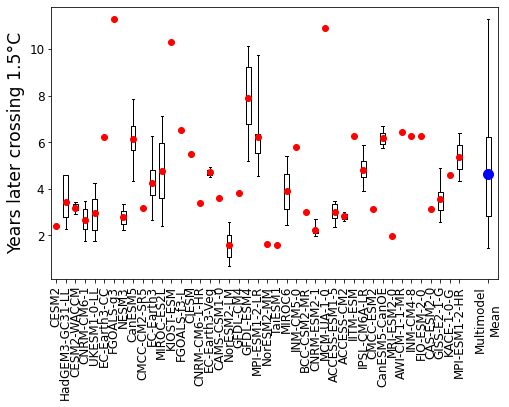

In [30]:
## plot

vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in models]
means = np.array([list(v)[0] for v in vectors])

fig, ax = plt.subplots(1,1,figsize=(8,5))

ax.boxplot(vectors,positions=np.arange(len(vectors)),whis=[0,100],
           showmeans=True,medianprops={'linewidth':0}, vert=True,
            meanprops={'marker':'o',
              'markerfacecolor':'r',
              'markeredgecolor':'r'})

mm_shift = 2

ax.boxplot(means,positions=[len(vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0,100],
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':10,
                      'markerfacecolor':'b',
                      'markeredgecolor':'b'},
          vert=True)

print(np.nanmean(means))
ax.set_xlim(-0.5,len(vectors)+mm_shift+1)
ax.set_xticklabels(list(models)+['Multimodel\nMean'],rotation=90)
ax.set_ylabel(f'Years later crossing {temp_thresh}°C',fontsize='x-large')


plt.show()

In [31]:
ordered_models = pd.DataFrame({'Model': models,
                               'Ensemble_members_count': None}).set_index('Model')
for model in ordered_models.index:
    count = len(out_df_ME[out_df_ME['Model']==model]['Ensemble_member'].unique())
    ordered_models['Ensemble_members_count'][model] = count

single_mem_models = ordered_models[ordered_models['Ensemble_members_count']==1]
multi_mem_models = ordered_models[ordered_models['Ensemble_members_count'] != 1]

#sort alphabetically for each category
single_mem_models.sort_index(inplace=True)
single_mem_models = single_mem_models[::-1]
single_mem_models['label'] = single_mem_models.index

multi_mem_models.sort_index(inplace=True)
multi_mem_models = multi_mem_models[::-1]
multi_mem_models['name'] = multi_mem_models.index
multi_mem_models['count'] = multi_mem_models['Ensemble_members_count'].apply(str)
multi_mem_models['label'] = multi_mem_models['name'] + ' (' + multi_mem_models['count'] + ')'

#recombine
ordered_models = pd.concat([multi_mem_models, single_mem_models])
ordered_models['name'] = ordered_models.index
ordered_models['count'] = ordered_models['Ensemble_members_count'].apply(str)

ordered_models['label'] = ordered_models['name'] + ' (' + ordered_models['count'] + ')'
ordered_models['label'] = ordered_models['label'].apply(lambda x: x.replace(" (1)", ""))
#ordered_models
#print(ordered_models)

Temp Thresh: 1.5
2036.5544651162784 1.0929013614084173 2031.843604651163 0.8750152019812394
gap:  4.710860465115275 +- 0.3905771187533693
% early 0.347550451065584
Temp Thresh: 2
2060.0046976744184 2.6099554944027075 2051.715860465116 1.8221719663803546
gap:  8.288837209302528 +- 1.0313502723116836
% early 0.22399418804150006


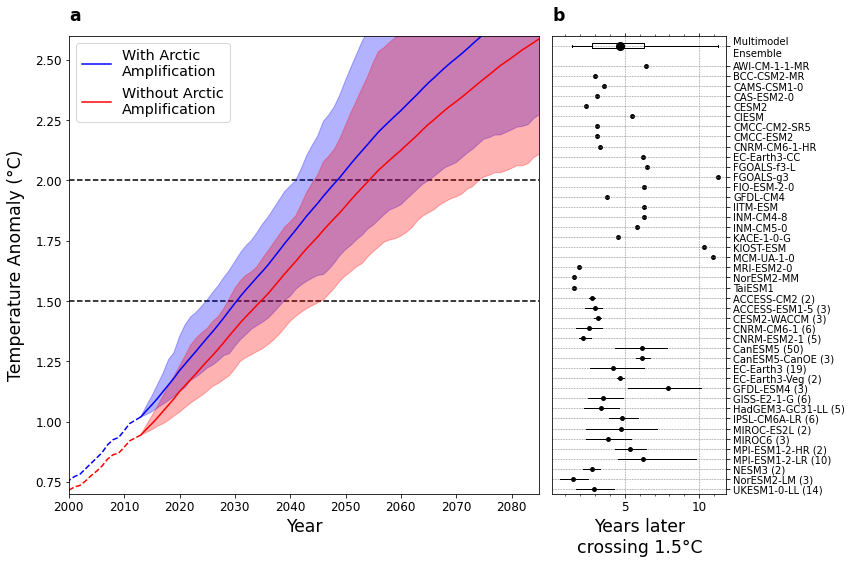

In [32]:
## combine both plots
add_ind_crossing_scatters=True
 
#models = ensemble_members['model']

vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in ordered_models.index]

means = np.array([list(v)[0] for v in vectors])
multi_mem_vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in multi_mem_models.index]
single_mem_vectors = [out_df_ME[out_df_ME['Model']==m]['gap'] for m in single_mem_models.index]
mean_vectors = [out_df_ME[out_df_ME['Model']==m]['gap'].mean() for m in ordered_models.index]


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8), gridspec_kw={'width_ratios': [2.7, 1]})
plt.rcParams['font.size'] = '12'

ax1.axhline(2, color='k',ls='--', zorder=0)
ax1.axhline(1.5, color='k',ls='--', zorder=0)

## add observations:
ax1.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', lw=1.5)
ax1.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', lw=1.5)

# legend_without_duplicate_labels(ax1,fontsize='large')
means_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].mean().dropna()
means_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].mean().dropna()
ax1.plot(means_blue.index.values,means_blue.values,lw=1.5,color='b', linestyle='-', label='With Arctic\nAmplification')
ax1.plot(means_red.index.values,means_red.values,lw=1.5,color='r', linestyle='-', label='Without Arctic\nAmplification')

quantiles=[0.10, 0.90]
bottom_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[0]).dropna()
top_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[1]).dropna()
bottom_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[0]).dropna()
top_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[1]).dropna()

ax1.fill_between(means_blue.index.values, bottom_blue.values, top_blue.values, color='b', alpha=0.3)
ax1.fill_between(means_red.index.values, bottom_red.values, top_red.values, color='r', alpha=0.3)         
ax1.legend(fontsize='large', loc='upper left')

ax1.set_xlim(2000,2085)
ax1.set_ylim(0.7, 2.6)

ax1.set_ylabel('Temperature Anomaly (°C)',fontsize='x-large', labelpad=10)
ax1.set_xlabel('Year',fontsize='x-large')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position('left')


###########################################
ax2.scatter(mean_vectors, ordered_models['label'], c='black', s=15)

ax2.boxplot(multi_mem_vectors,positions=np.arange(len(multi_mem_vectors)),whis=[0, 100],
           showmeans=False, vert=False, showbox=True, showfliers=False, widths=0,
            medianprops={'linewidth':0},
            meanprops={'marker':'o', 
                       'markersize':5,
              'markerfacecolor':'black',
              'markeredgecolor':'black'},
           boxprops={})

mm_shift = 1

ax2.boxplot(out_dfs[1.5]['gap'],positions=[len(multi_mem_vectors)+len(single_mem_vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[0, 100], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)


ax2.set_ylim(-0.5,len(vectors)+mm_shift+1)
ax2.set_xlabel(f'Years later\ncrossing {temp_thresh}°C',fontsize='x-large')

ax2.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.set_yticks(np.delete(np.arange(len(vectors)+mm_shift+1), -2, 0))
ax2.set_yticklabels(list(ordered_models['label'])+['Multimodel\nEnsemble'],rotation=0, fontsize='small')  
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')


markersize=100
marker='o'
for thresh in [1.5,2]:
    
    out_df = out_dfs[thresh]
    
    #x,y = np.median(out_df['No_arctic_crossing_year']), np.median(out_df['World_crossing_year'])
    x,y = np.mean(out_df['No_arctic_crossing_year']), np.mean(out_df['World_crossing_year'])
    z = stats.sem(out_df['gap'], nan_policy='omit')
    x_e, y_e = stats.sem(out_df['No_arctic_crossing_year'], nan_policy='omit'), stats.sem(out_df['World_crossing_year'], nan_policy='omit')
    #ax1.scatter(x,thresh,color='r',marker=marker,s=markersize)
    #ax1.scatter(y,thresh,color='b',marker=marker,s=markersize)
    
    print(f'Temp Thresh: {thresh}')
    print(x, x_e, y, y_e)
    print('gap: ', x-y, '+-', z)
    print('% early', (x-y)/(x-2023))
    

#plt.text(0, 1, 'b', fontsize='x-large', transform=ax.transAxes)
         
# fig = plt.gcf()



ax1.set_title('a', weight='bold', fontsize='x-large', loc='left', pad=15)
ax2.set_title('b', weight='bold', fontsize='x-large', loc='left', pad=15)
plt.tight_layout()

plt.savefig('Figures/Combined_{}.png'.format(exp), dpi=300)

#plt.show()

In [33]:
year=2050
def ratio_of_intermodel_spread(year):
    w_e = stats.sem(M_df[M_df['year']==year]['adjusted_world_tas_anom'])
    na_e = stats.sem(M_df[M_df['year']==year]['adjusted_no_arctic_tas_anom'])
    print(w_e, na_e)
    print(((w_e-na_e)/na_e))

#for year in np.arange(2040, 2095, 1):
#    ratio_of_intermodel_spread(year)
ratio_of_intermodel_spread(year)

0.049726302197979466 0.04525285867723053
0.09885438514848566


In [34]:
print('number of models: ', len(M_df[M_df['year']==2090]))
print('number of ensemble members: ', len(out_df_ME))

number of models:  43
number of ensemble members:  172


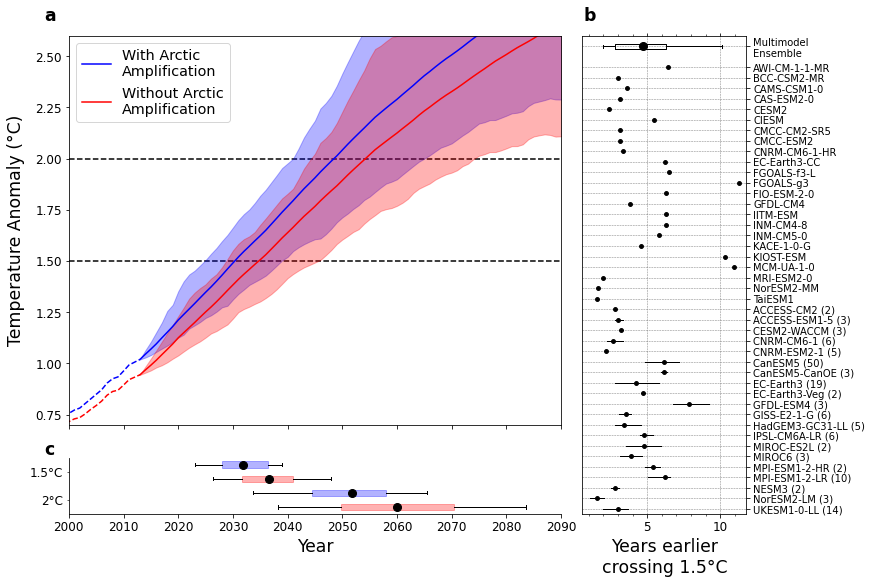

In [35]:

out_dfs[1.5]['thresh'] = '1.5'
out_dfs[2]['thresh'] = '2'

out_dfs_concat = pd.concat([out_dfs[1.5], out_dfs[2]])


### combine all 4 panels
fig = plt.figure(constrained_layout=True, figsize=(12,8))
gs = fig.add_gridspec(6, 4)
ax1 = fig.add_subplot(gs[0:-1, :-1])
ax1.axhline(2, color='k',ls='--', zorder=0)
ax1.axhline(1.5, color='k',ls='--', zorder=0)

arrows = False #sets whether annoted arrows are plotted

## add observations:
ax1.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', lw=1.5)
ax1.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', lw=1.5)

# legend_without_duplicate_labels(ax1,fontsize='large')
means_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].mean().dropna()
means_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].mean().dropna()
ax1.plot(means_blue.index.values,means_blue.values,lw=1.5,color='b', linestyle='-', label='With Arctic\nAmplification')
ax1.plot(means_red.index.values,means_red.values,lw=1.5,color='r', linestyle='-', label='Without Arctic\nAmplification')

quantiles=[0.10, 0.90]
bottom_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[0]).dropna()
top_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[1]).dropna()
bottom_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[0]).dropna()
top_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[1]).dropna()

ax1.fill_between(means_blue.index.values, bottom_blue.values, top_blue.values, color='b', alpha=0.3)
ax1.fill_between(means_red.index.values, bottom_red.values, top_red.values, color='r', alpha=0.3)
         
ax1.legend(fontsize='large', loc='upper left')


ax1.set_xlim(2000,2090)
ax1.set_ylim(0.7, 2.6)

ax1.set_ylabel('Temperature Anomaly (°C)',fontsize='x-large', labelpad=10)
#ax1.set_xlabel('Year',fontsize='x-large')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position('left')
plt.setp(ax1.get_xticklabels(), visible=False)

#############################################################

ax2 = fig.add_subplot(gs[:, -1])


ax2.scatter(mean_vectors, ordered_models['label'], c='black', s=15, zorder=1000)

ax2.boxplot(multi_mem_vectors,positions=np.arange(len(multi_mem_vectors)),whis=[5, 95],
           showmeans=False, vert=False, showbox=True, showfliers=False, widths=0,
            medianprops={'linewidth':0},
            meanprops={'marker':'o', 
                       'markersize':5,
              'markerfacecolor':'black',
              'markeredgecolor':'black'},
           boxprops={})

mm_shift = 1

ax2.boxplot(out_dfs[1.5]['gap'],positions=[len(multi_mem_vectors)+len(single_mem_vectors)+mm_shift],widths=0.5,
           showmeans=True,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)

ax2.set_ylim(-0.5,len(vectors)+mm_shift+1)
ax2.set_xlabel(f'Years earlier\ncrossing {temp_thresh}°C',fontsize='x-large')

ax2.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.set_yticks(np.delete(np.arange(len(vectors)+mm_shift+1), -2, 0))
ax2.set_yticklabels(list(ordered_models['label'])+['Multimodel\nEnsemble'],rotation=0, fontsize='small')  
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')



ax4 = fig.add_subplot(gs[5, :-1], sharex=ax1)
#ax4.set_title('c')


boxes = [out_dfs[1.5]['World_crossing_year'], out_dfs[1.5]['No_arctic_crossing_year'],
        out_dfs[2]['World_crossing_year'], out_dfs[2]['No_arctic_crossing_year']]
boxes.reverse()

#sns.stripplot(ax=ax4, data=boxes, orient='h', 
#              palette=['b', 'r', 'b', 'r'], alpha=0.5)

colors = ['red', 'blue', 'red', 'blue']
bplot = ax4.boxplot(boxes,positions=np.arange(len(boxes)),whis=[5,95], showfliers=False,
           showmeans=True, vert=False,  patch_artist=True,
            medianprops={'linewidth':0},
            meanprops={'marker':'o', 
                       'markersize':8,
              'markerfacecolor':'black',
              'markeredgecolor':'black'}, 
            zorder=1000)


for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    patch.set_alpha(0.3)


ax4.set_xlabel('Year',fontsize='x-large')
ax4.set_yticks([0,1,2,3])
#ax4.set_yticklabels(['1.5C', '', '2C', ''])
ax4.set_yticklabels(['', '', '', ''])
ax4.yaxis.set_minor_locator(ticker.FixedLocator([0.5,2.5]))
ax4.yaxis.set_minor_formatter(ticker.FixedFormatter(['2°C','1.5°C']))
ax4.tick_params(axis='y', which='major', length=0)

#ax4.set_ylabel('Threshold (°C)',fontsize='x-large', labelpad=10)

ax1.set_title('a', weight='bold', fontsize='x-large', loc='left', pad=15, x=-0.05)
ax2.set_title('b', weight='bold', fontsize='x-large', loc='left', pad=15, x=0.01)
#ax3.set_title('c', weight='bold', fontsize='x-large', loc='left', pad=15)
ax4.set_title('c', y=0.95, weight='bold', fontsize='x-large', loc='left', x =-0.05)
#ax4.annotate("", (2030, 0), (10, 0), arrowprops = dict(arrowstyle="<->"))

y1 = 3.7
delta_y = 0.3
y2 = 2.5

if arrows:
    ax4.annotate("", (np.mean(out_dfs[1.5]['World_crossing_year']), y1), 
                 xytext=(np.mean(out_dfs[1.5]['No_arctic_crossing_year']), y1), 
                 xycoords='data', textcoords='data', 
                 arrowprops=dict(arrowstyle="->"), annotation_clip=False)
    ax4.annotate("", (np.mean(out_dfs[2]['World_crossing_year']), y2), 
                 xytext=(np.mean(out_dfs[2]['No_arctic_crossing_year']), y2), 
                 xycoords='data', textcoords='data', 
                 arrowprops=dict(arrowstyle="->"), annotation_clip=False)
    ax4.annotate("{}".format(str(np.round(np.mean(out_dfs[1.5]['No_arctic_crossing_year']) - np.mean(out_dfs[1.5]['World_crossing_year']), 1))),
                 xy=((np.mean(out_dfs[1.5]['World_crossing_year']) + np.mean(out_dfs[1.5]['No_arctic_crossing_year']))/2, y1+delta_y), 
                 textcoords='data', 
                 annotation_clip=False,
                 horizontalalignment='center')
    ax4.annotate("{}".format(str(np.round(np.mean(out_dfs[2]['No_arctic_crossing_year']) - np.mean(out_dfs[2]['World_crossing_year']), 1))),
                 xy=((np.mean(out_dfs[2]['World_crossing_year']) + np.mean(out_dfs[2]['No_arctic_crossing_year']))/2, y2+delta_y), 
                 textcoords='data', 
                 annotation_clip=False,
                horizontalalignment='center')
ax4.spines[['top', 'right']].set_visible(False)
#plt.tight_layout()

plt.savefig('Figures/Combined_all_{}.png'.format(exp), dpi=300)
plt.show()

In [36]:
## t-test the distributions

p15 = stats.ttest_ind(out_dfs[1.5]['World_crossing_year'], out_dfs[1.5]['No_arctic_crossing_year'],
                axis=0, equal_var=True, nan_policy='propagate', permutations=100000, 
                alternative='less').pvalue

p2 = stats.ttest_ind(out_dfs[2]['World_crossing_year'], out_dfs[2]['No_arctic_crossing_year'],
                axis=0, equal_var=True, nan_policy='propagate', permutations=100000, 
                alternative='less').pvalue

print('pvalue for difference in means of 1.5 crossing: ', str(p15))
print('pvalue for difference in means of 1.5 crossing: ', str(p2))

pvalue for difference in means of 1.5 crossing:  0.00067
pvalue for difference in means of 1.5 crossing:  0.00471


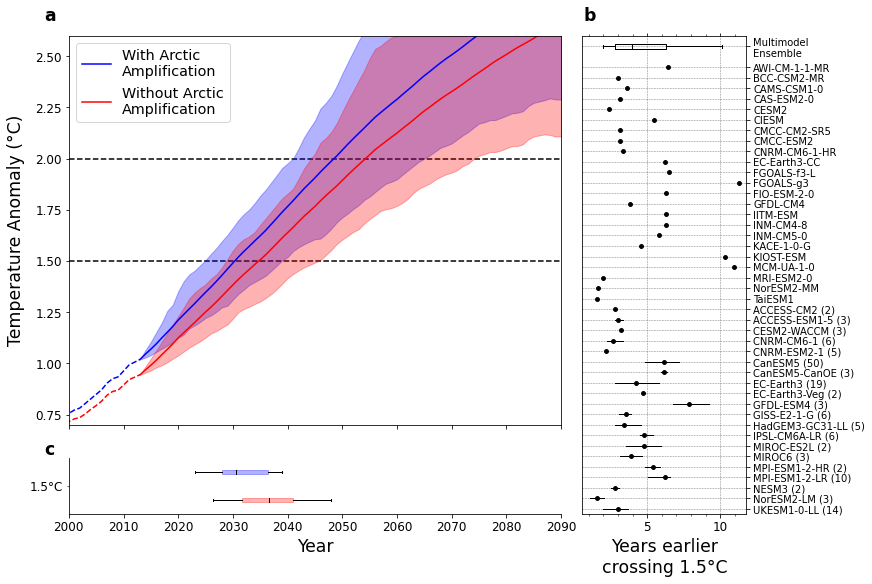

Temp Thresh: 2
2036.559 2030.53
% early 0.44464931042112327


In [37]:
### additional main plot for ssp126 using medians and dropping nans

out_df_nan = out_dfs[1.5]
out_df_nan = out_df_nan.dropna(subset = ['World_crossing_year']) #exclude any models that don't cross in either scenario from analysis
out_df_nan = out_df_nan.replace({np.nan: 10000})
#out_dfs[1.5] = out_dfs[1.5].dropna()

### combine all 4 panels
fig = plt.figure(constrained_layout=True, figsize=(12,8))
gs = fig.add_gridspec(6, 4)
ax1 = fig.add_subplot(gs[0:-1, :-1])
ax1.axhline(2, color='k',ls='--', zorder=0)
ax1.axhline(1.5, color='k',ls='--', zorder=0)

## add observations:
ax1.plot(Obs_df['year'], Obs_df['world_tas'], c='blue', 
         linestyle='--', lw=1.5)
ax1.plot(Obs_df['year'], Obs_df['no_arctic_tas'], c='red', 
         linestyle='--', lw=1.5)

# legend_without_duplicate_labels(ax1,fontsize='large')
means_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].mean().dropna()
means_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].mean().dropna()
ax1.plot(means_blue.index.values,means_blue.values,lw=1.5,color='b', linestyle='-', label='With Arctic\nAmplification')
ax1.plot(means_red.index.values,means_red.values,lw=1.5,color='r', linestyle='-', label='Without Arctic\nAmplification')

quantiles=[0.10, 0.90]
bottom_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[0]).dropna()
top_blue = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_world_tas_anom'].quantile(q=quantiles[1]).dropna()
bottom_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[0]).dropna()
top_red = M_df[M_df['year']>=obs_year].groupby('year')['adjusted_no_arctic_tas_anom'].quantile(q=quantiles[1]).dropna()

ax1.fill_between(means_blue.index.values, bottom_blue.values, top_blue.values, color='b', alpha=0.3)
ax1.fill_between(means_red.index.values, bottom_red.values, top_red.values, color='r', alpha=0.3)
         
ax1.legend(fontsize='large', loc='upper left')


ax1.set_xlim(2000,2090)
ax1.set_ylim(0.7, 2.6)

ax1.set_ylabel('Temperature Anomaly (°C)',fontsize='x-large', labelpad=10)
#ax1.set_xlabel('Year',fontsize='x-large')
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position('left')
plt.setp(ax1.get_xticklabels(), visible=False)

#############################################################

ax2 = fig.add_subplot(gs[:, -1])


ax2.scatter(mean_vectors, ordered_models['label'], c='black', s=15, zorder=1000)

ax2.boxplot(multi_mem_vectors,positions=np.arange(len(multi_mem_vectors)),whis=[5, 95],
           showmeans=False, vert=False, showbox=True, showfliers=False, widths=0,
            medianprops={'linewidth':0},
            meanprops={'marker':'o', 
                       'markersize':5,
              'markerfacecolor':'black',
              'markeredgecolor':'black'},
           boxprops={})

mm_shift = 1

ax2.boxplot(out_df_nan['gap'],positions=[len(multi_mem_vectors)+len(single_mem_vectors)+mm_shift],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
            medianprops={'color':'black'},
          vert=False)

ax2.set_ylim(-0.5,len(vectors)+mm_shift+1)

#using the infinite crossing years for nans, 95th %ile is infite, so restrict x-axis to see data
if exp == 'ssp126':
    ax2.set_xlim(0, 26)
    
ax2.set_xlabel(f'Years earlier\ncrossing 1.5°C',fontsize='x-large')

ax2.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
ax2.set_yticks(np.delete(np.arange(len(vectors)+mm_shift+1), -2, 0))
ax2.set_yticklabels(list(ordered_models['label'])+['Multimodel\nEnsemble'],rotation=0, fontsize='small')  
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')



ax4 = fig.add_subplot(gs[5, :-1], sharex=ax1)
#ax4.set_title('c')


boxes = [out_df_nan['World_crossing_year'], out_df_nan['No_arctic_crossing_year']]
boxes.reverse()

#sns.stripplot(ax=ax4, data=boxes, orient='h', 
#              palette=['b', 'r', 'b', 'r'], alpha=0.5)

colors = ['red', 'blue']
bplot = ax4.boxplot(boxes,positions=np.arange(len(boxes)),whis=[5,95], showfliers=False,
           showmeans=False, vert=False,  patch_artist=True, 
            medianprops={'color':'black',
                         'markerfacecolor':'black',
              'markeredgecolor':'black'},
            zorder=1000)


for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    patch.set_alpha(0.3)


ax4.set_xlabel('Year',fontsize='x-large')
ax4.set_yticks([0,1])
#ax4.set_yticklabels(['1.5C', '', '2C', ''])
ax4.set_yticklabels(['', ''])
ax4.yaxis.set_minor_locator(ticker.FixedLocator([0.5]))
ax4.yaxis.set_minor_formatter(ticker.FixedFormatter(['1.5°C']))
ax4.tick_params(axis='y', which='major', length=0)

#ax4.set_ylabel('Threshold (°C)',fontsize='x-large', labelpad=10)

ax1.set_title('a', weight='bold', fontsize='x-large', loc='left', pad=15, x=-0.05)
ax2.set_title('b', weight='bold', fontsize='x-large', loc='left', pad=15, x=0.01)
#ax3.set_title('c', weight='bold', fontsize='x-large', loc='left', pad=15)
ax4.set_title('c', y=0.95, weight='bold', fontsize='x-large', loc='left', x =-0.05)
#ax4.annotate("", (2030, 0), (10, 0), arrowprops = dict(arrowstyle="<->"))

y1 = 1.7
delta_y = 0.3
y2 = 2.5

if arrows:
    ax4.annotate("", (np.median(out_df_nan['World_crossing_year']), y1), 
                 xytext=(np.median(out_df_nan['No_arctic_crossing_year']), y1), 
                 xycoords='data', textcoords='data', 
                 arrowprops=dict(arrowstyle="->"), annotation_clip=False)
    ax4.annotate("{}".format(str(np.round(np.median(out_df_nan['No_arctic_crossing_year']) - np.median(out_df_nan['World_crossing_year']), 1))),
                 xy=((np.median(out_df_nan['World_crossing_year']) + np.median(out_df_nan['No_arctic_crossing_year']))/2, y1+delta_y), 
                 textcoords='data', 
                 annotation_clip=False,
                 horizontalalignment='center')
ax4.spines[['top', 'right']].set_visible(False)
#plt.tight_layout()
if exp =='ssp126':
    plt.savefig('Figures/Combined_all_{}.png'.format(exp), dpi=300)
plt.show()


x,y = np.median(out_df_nan['No_arctic_crossing_year']), np.median(out_df_nan['World_crossing_year'])
#z = stats.sem(out_df_nan['gap'], nan_policy='omit')
#x_e, y_e = stats.sem(out_df_nan['No_arctic_crossing_year'], nan_policy='omit'), stats.sem(out_df_nan['World_crossing_year'], nan_policy='omit')
#ax1.scatter(x,thresh,color='r',marker=marker,s=markersize)
#ax1.scatter(y,thresh,color='b',marker=marker,s=markersize)

print(f'Temp Thresh: {thresh}')
print(x, y)
#print('gap: ', x-y, '+-', z)
print('% early', (x-y)/(x-2023))
    

In [38]:
## t-test the distributions

p15 = stats.ttest_ind(out_dfs[1.5]['World_crossing_year'], out_dfs[1.5]['No_arctic_crossing_year'],
                axis=0, equal_var=True, nan_policy='propagate', permutations=100000, 
                alternative='less').pvalue

print('pvalue for difference in means of 1.5 crossing: ', str(p15))


pvalue for difference in means of 1.5 crossing:  0.00046
